# 7. 새와 비행기 구별하기 : 이미지 학습

## 7.1 : 작은 이미지를 모아 놓은 데이터셋

### 7.1.1 CIFAR-10 다운로드

In [ ]:
import torch
from torchvision import datasets
data_path = '../data-unversioned/plch7/'
cifar10 = datasets.CIFAR10(data_path, train = True, download= True)
cifar10_val = datasets.CIFAR10(data_path, train = False, download= True)

In [ ]:
type(cifar10).__mro__

### 7.1.2 데이터셋 클래스
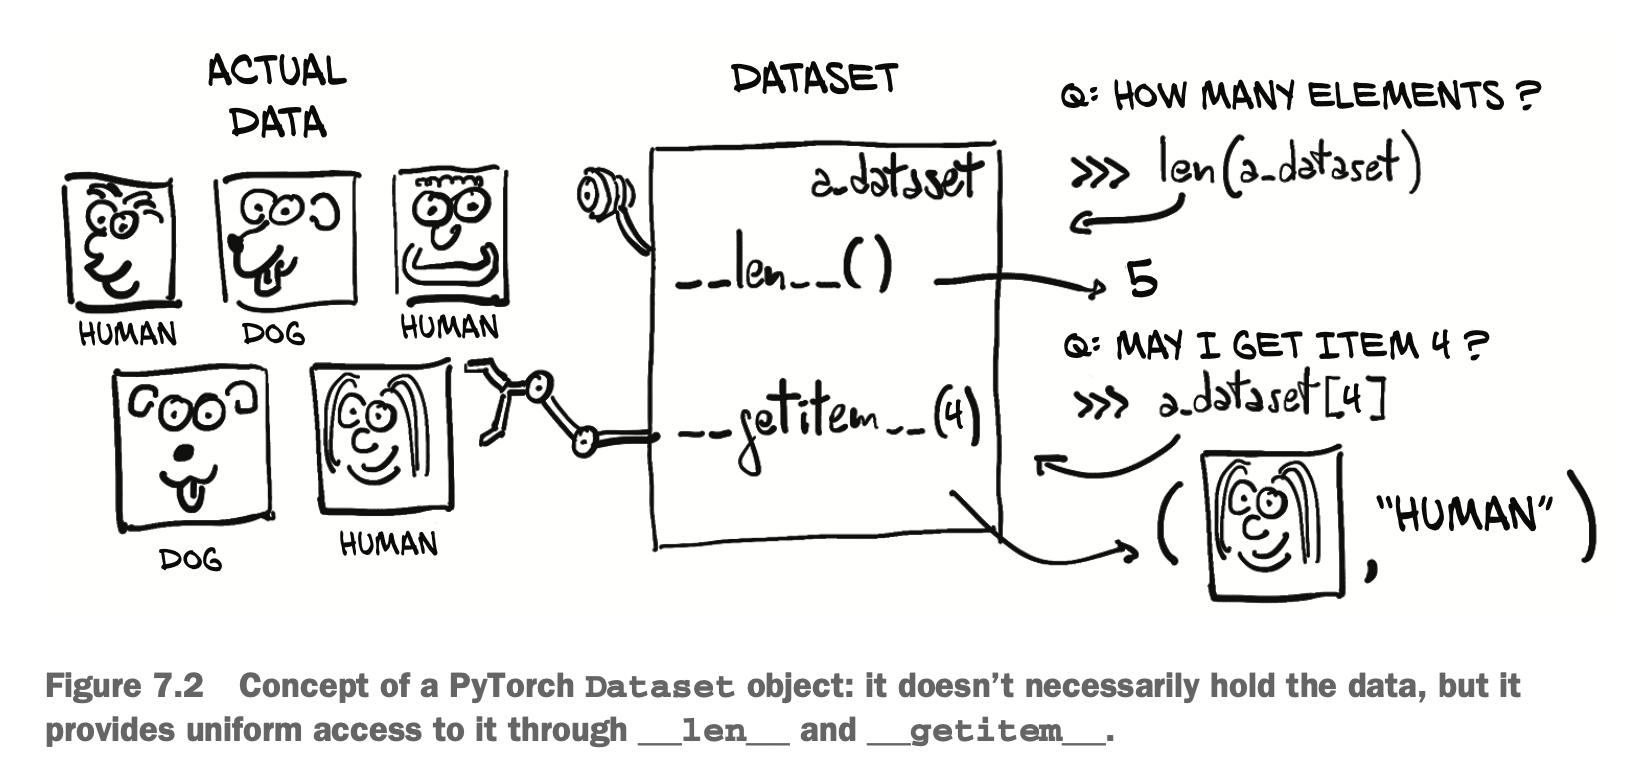

In [ ]:
from matplotlib import pyplot as plt
len(cifar10)

img,label = cifar10[99]

plt.imshow(img) # 붉은색 자동차다!


### 7.1.3 데이터 변환
- 이제 PIL 이미지를 파이토치 텐서로 변환할 단계이다.
- PIL python image library

```
# This is formatted as code
```



In [ ]:
from torchvision import transforms
# dir(transforms)


# ToTensor : 넘파이 배열과 PIL 이미지를 텐서로 바꾸는 역할 + 출력 텐서의 차원 레이아웃을 C * H * W 로 맞춰 준다.
# ToTensor 변환을 사용해보자

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

 # torch.Size([3, 32, 32]) : 이미지가 3 * 32 * 32 텐서로 바뀌었다.
 # 이제  RGB 3개의 채널을 가지는 32 * 32 이미지가 되었다.
 # label 값은 변동없이 정수값을 그대로 가진다.

# 이렇게도 가능하다
tensor_cifar10 = datasets.CIFAR10(data_path, train = True, download=True, transform=transforms.ToTensor())




In [ ]:
# 이제 데이터셋의 요소를 접근하면 PIL 이미지가 아닌 텐서를 리턴한다.
img_t , _ = tensor_cifar10[99]

type(img) # PIL.Image.Image
type(img_t) # torch.Tensor

img_t.shape , img_t.dtype #  (torch.Size([3, 32, 32]), torch.float32)

'''
원본 PIL 이미지 값은 0에서 255 범위(채널 당 8비트)
ToTensor 변환으로 데이터가 채널 당 32비트 부동소수점 형태가 되면서 값이 0.0에서 1.0 사이로 범위가 줄어든다.
'''

img_t.min() , img_t.max()
plt.imshow(img_t.permute(1,2,0))
# plt.imshow(img_t) -> TypeError: Invalid shape (3, 32, 32) for image data 에러 발생


# permute : C * H * W 를 H * W * C로 바꿔준다.
# matplotlib가 기대하는 H * W* C 형태를 위해 변경


### 7.1.4 데이터 정규화
- 데이터 정규화로 각 채널이 평균값 0과 단위 표준 편차를 가지게 만드는 연습

In [ ]:
list(tensor_cifar10)[0]

# 원래는  img_t : 변환된 이미지 텐서와 label(여기서는 6이 있다.)

In [ ]:
imgs = torch.stack([img_t for img_t, label in tensor_cifar10],dim = 3)

In [ ]:
imgs.shape

In [ ]:
# 이제 채널별로 평균을 계산해보자
# imgs : 여러 장의 이미지가 쌓인 4차원 텐서
# .view(3,-1) : 텐서를 (3, 나머지 모두)로 2차원으로 펼치는 것
# 결과 shape : (3, 전체 픽셀 수 * 이미지 개수)

# 이미지 텐서 형태 : (채널, 높이, 너비)
# view(3, -1) → (3, 32*32*50000) = (3, 51200000)

# .mean(dim = 1) : 각 채널별로 모든 픽셀과 이미지에 대해 평균값을 구함.

viewed_imgs = imgs.view(3,-1)

print(viewed_imgs.shape)
# print(viewed_imgs.mean())
# print(viewed_imgs[: ,0])

'''
R 값1 값2
G 값1 값2
B 값1 값2

이제 R, G,B 별로 평균을 계산해야하니까 dim=1(가로 방향)으로 평균을 구해준다.
'''
print(viewed_imgs.mean(dim=1)) # 열방향으로 각 채널별로 평균을 구하기 위함

# 표준편차 계산
print(imgs.view(3,-1).std(dim=1))

# 각 채널과 표준 편차를 계산해서 v_n[c] = (v[c] - mean[c]) / stdev[c]를 하면된다.
# 이게 transform.Normalize가 하는 일 !

transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

# 이제 ToTensor 변환을 이어붙이다.

transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))
    ])
)

In [ ]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

# 이제 원래 이미지와 많이 다른 모습이다!!

## 7.2 새와 비행기를 구별하기
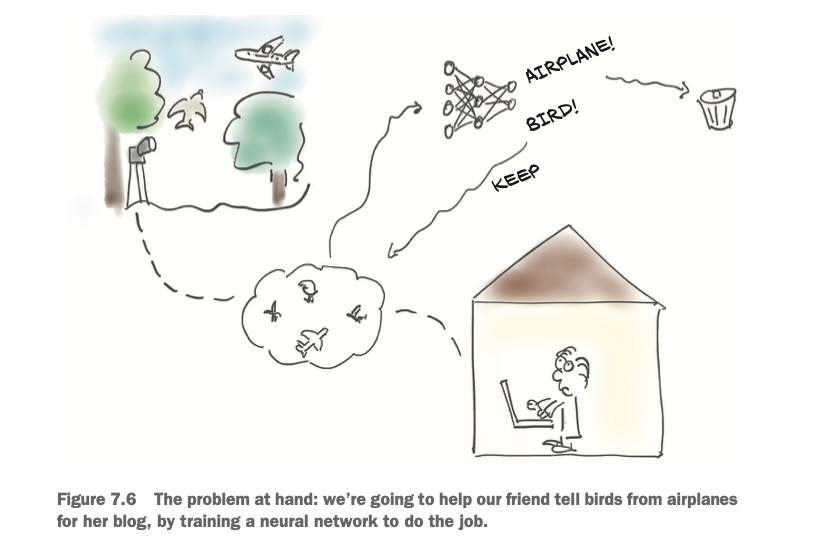
- 제인은 여러 대의 카메라를 숲에 설치하고는 카메라 프레임 안에 뭔가가 들어오면 찍어서 바로 실시간 탐조 블로으게 업로드 하게 되어있다.
- 문제는 새뿐만 아니라 비행기도 찍힌다는 점이다.
- 제인은 수동으로 비행기 사진을 삭제하는 대신 비행기를 바로 지워줄 신경망, 즉 AI가 필요하다.

- CIFAR10 데이터에서 새와 비행기를 골라낸 후 신경망을 만들어 새와 비행기를 구분해보자.

### 7.2.1 데이터 구축
- 가장 먼저 할 일은 데이터의 차원 정보를 맞추는 일이다.
- 새와 비행기만 들어간 Dataset 서브 클래스를 만든다.
- 여기서는 데이터셋이 작고 , 인덱싱과 len만 잇으면 되기 때문에 torch.utils.data.datasets.Dataset의 서브 클래스일 필요가 없다.
- cifar10에 있는 데이터를 필터링하고 레이블을 다시 매핑해서 만들어보자.

In [ ]:
# label 0은 "비행기", label 2는 "새"를 의미함
# 새와 비행기를 구분하기 위해 0과 1로 구분해줄거다.

label_map =  {0:0, 2:1}
class_names = ['airplane','bird']

cifar2 = [(img,label_map[label]) for img, label in transformed_cifar10 if label in [0,2]]

cifar2_val = [(img,label_map[label]) for img,label in transformed_cifar10_val if label in [0,2]]


cifar2[0] # (<PIL.Image.Image image mode=RGB size=32x32>, 1)


### 7.2.2 완전 연결 모델
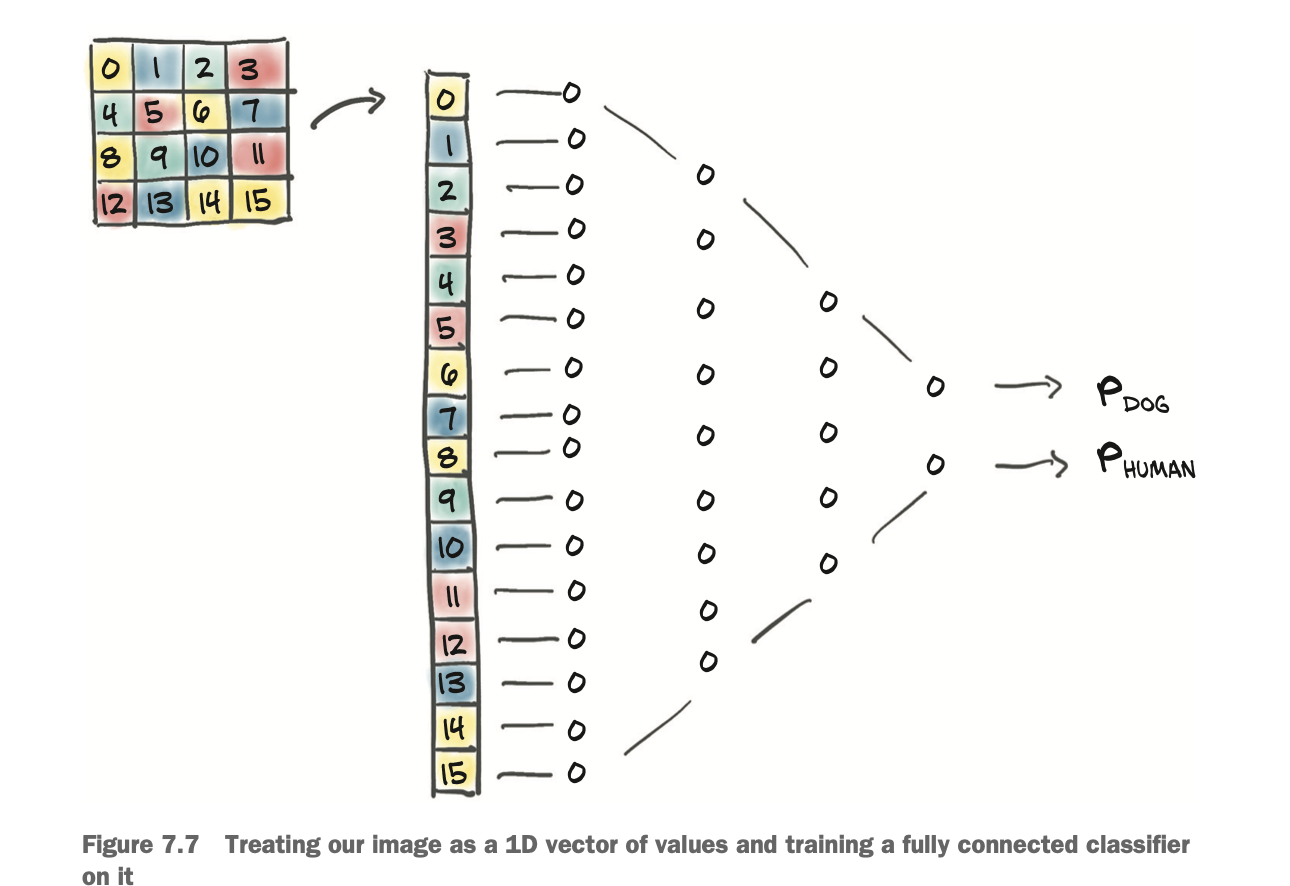

- 이미지 픽셀을 받아서 긴 1차원 벡터로 늘어뜨린다면 결국 일련의 숫자들을 입력 피처로 볼 수 있지 않을까?

- 32*32*3 이니까 샘플마다 3072개의 입력피처가 있는 셈이다.
- 5장에서 만든 모델에서 출발해 우리의 새로운 모델은 nn.Linear이면서 입력 피처가 3072이고, 몇 개의 히든 피처를 거쳐활성함수로 이어지게 만들자.
이후 다른 nn.Linear로 신경망을 줄여나가면서 원하는 출력 피처 수(2)를 맞춰보자

In [ ]:
import torch.nn as nn

n_out = 2
model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

'''
은닉된 피처는 가중치 행렬로 인코딩된 입력값들 간의 학습된 관계를 나타낸다.
The hidden features represent (learned)
relations between the inputs encoded through the weight matrix


각 nn.Linear 레이어는 가중치 행렬(weight matrix)를 가지고 있다.
이 가중치 행렬은 입력값들(이미지 픽셀들) 사이의 관계와 패턴을 학습해서, 어떤 조합이 중요한지 스스로 찾아낸다.
즉 은닉 피처는 입력값들 사이의 복잡한 상호작용을 가중치 행렬이 인코딩(압축)해서 만들어낸 결과라고 볼 수 있다.

'''

### 7.2.3 분류기의 출력
- 6장에서는 예측온도값을 출력했다.
- 신경망이 단일 스칼라값(n_out = 1)을 출력하게 하고
- 레이블을 부동 소수점 수로 변환한 후 (비행기는 0.0, 새는 1.0)
- 이를 MSELoss의 타깃으로 사용한다.
- 이렇게 해서 문제를 회귀 문제로 만든다.

---
- 출력값은 카테고리이다.
- 카테고리변수를 표현할 때에는 원 핫 인코딩을 적용해야한다.
    - [1,0] -> 비행기
    - [0,1] -> 새
- 이상적인 신경망은 비행기에 대해 torch.tensor([1.0, 0.0])을 출력하고 새에 대해 torch.tensor([0.0, 1.0])을 출력할 때지만 실제 분류기는 완벽하지 않으므로 출력값은 0과 1 사이가 될 것이다.

- **여기서 우리는 출력을 확률로 볼 수 있다.**
- 출력을 확률을 보기 때문에
    - 출력값의 요소가 가질 수 있는 값은 [0.0, 1.0] 범위로 제한된다.
    - 모든 출력 요소의 값의 합은 1.0이다.


### 7.2.4 출력을 확률로 표현하기
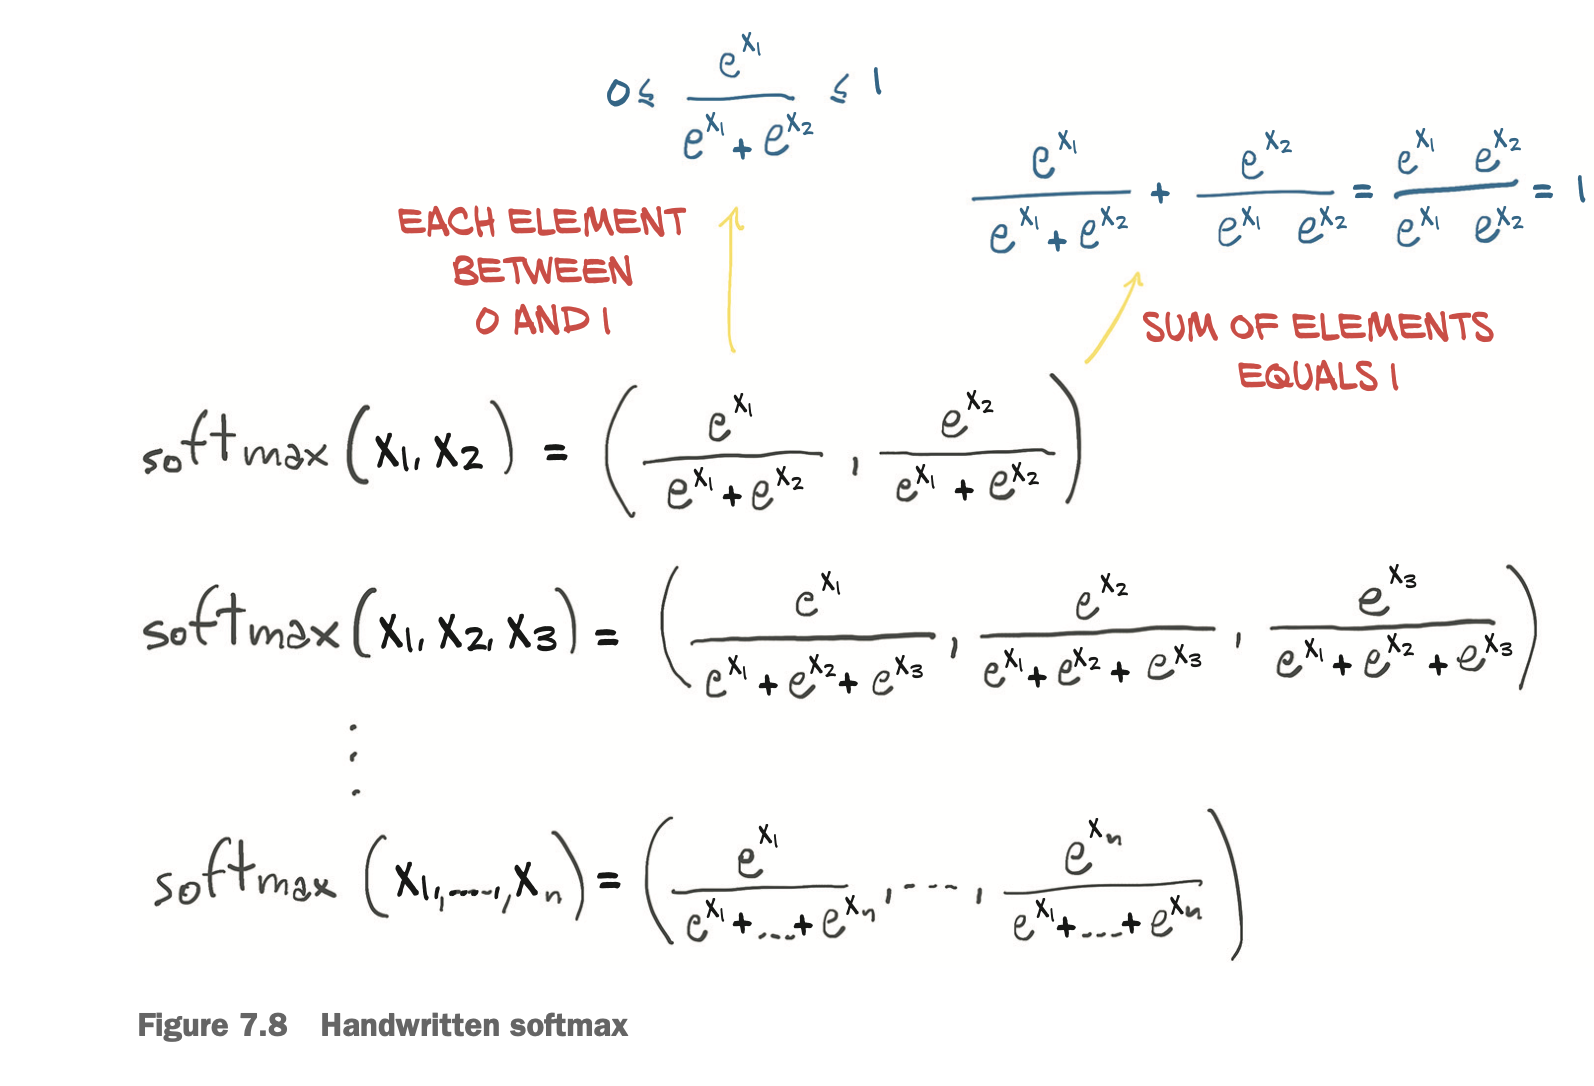

In [ ]:
# 소프트맥스 함수 구현

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [ ]:
# 입력 벡터로 테스트 해보자

x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)
# tensor([0.0900, 0.2447, 0.6652])

# Pytorch의 nn.Sofrmax는 입력 텐서의 특정 차원(dim)에 따라 소프트맥스  연산을 적용한다.


In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0,2.0,3.0],
                 [1.0,2.0,3.0]])

softmax(x)

In [ ]:
model = nn.Sequential(
    nn.Linear(3*32*32, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.Softmax(dim=1)
)

In [ ]:
img, _  = cifar2[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
# 모델을 호출하려면 먼저 입력 차원이 맞아야한다.

'''
and that nn works with data organized into batches along the zeroth dimension.

Pytorch 신경망(nn.Module)들이 입력 데이터를 항상 배치 단위로 처리하며,이 배치가 텐서의 0번째 차원에 위치한다는 뜻

we need to
turn our 3 × 32 × 32 image into a 1D tensor

and then add an extra dimension in the
zeroth position.

'''


img.view(-1).shape
img_batch = img.view(-1).unsqueeze(0)

# view(-1) : 텐서의 모든 원소를 1차원 벡터로 펼치는 코드

#img_t.view(1).shape
# view(1)은 텐서의 shape를 (1,)로 바꾸려는 시도이다.
# 원소 1개인 1차원 텐서로 만들겠다.

 # 성공 : 원래 텐서에 원소가 딱 1개만 있으면 가능
 # 실패 : 원래 텐서에 원소가 2개 이상이면 에러 발생

In [ ]:
out = model(img_batch)
out
index = torch.max(out,dim=1)
index

# 여기서 나온 건 우연한 결과이다.
# 이제 훈련 중 최소화할 손실 값이 필요하다.

### 7.2.5 분류를 위한 손실값
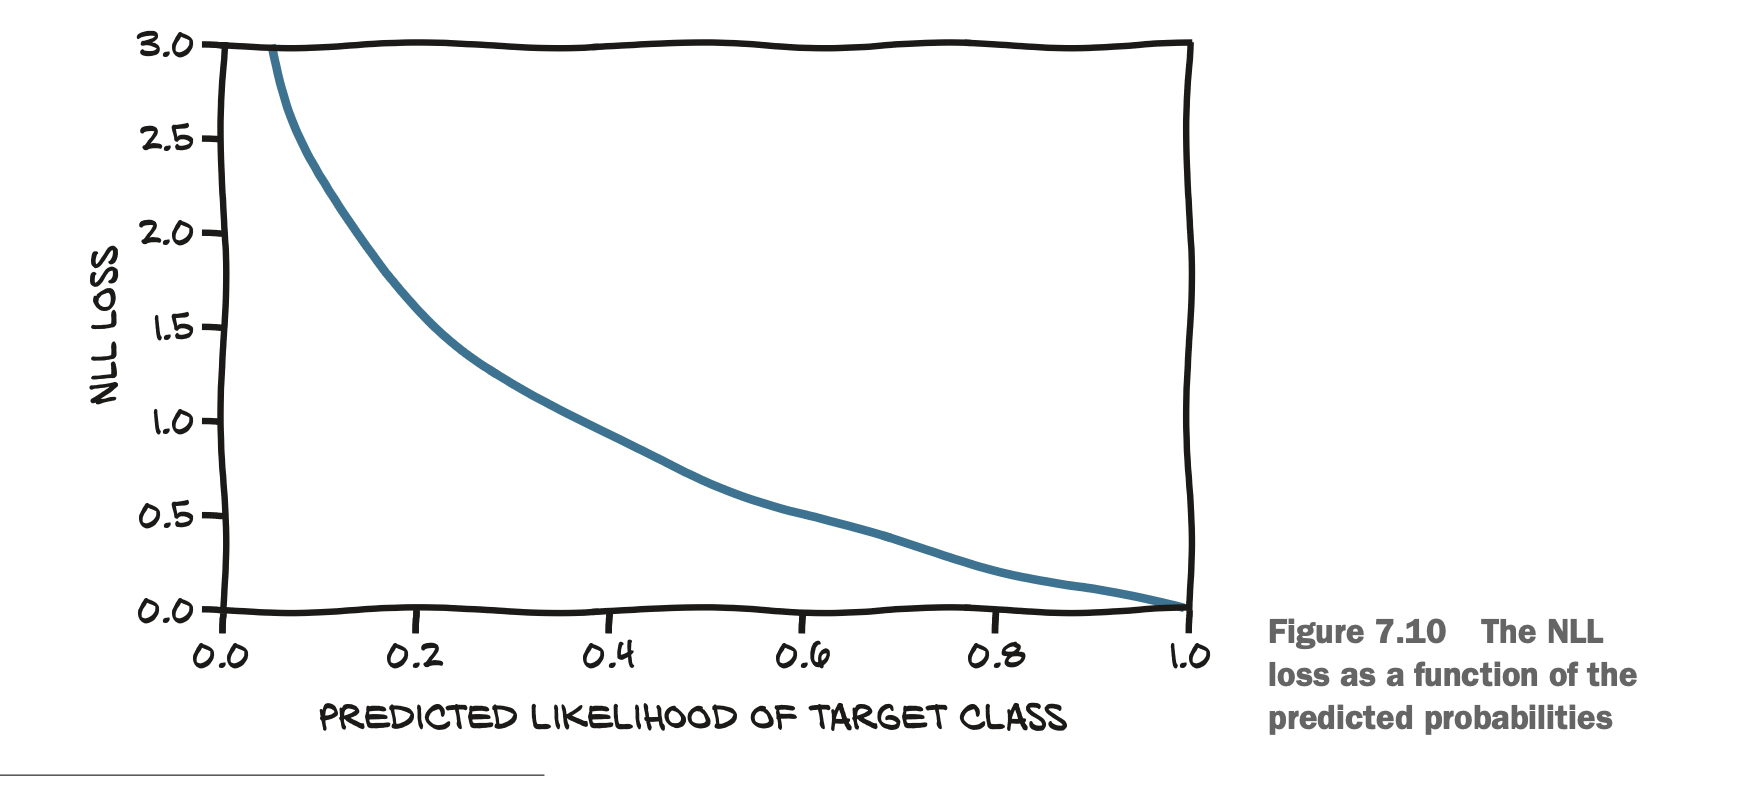

- 분류를 위한 손실 계산 방법

1. 순방향 전달 후 마지막 선형 계층에서 출력값을 얻는다.
2. 이들의 소프트매긋 값을 계산하여 확률을 얻는다.
3. 정답 클래스와 일치하는 예측 확률값을 얻는다. supervised 문제이기 때문에 실측값이 존재하므로 정답클래스를 안다고 가정할 수 있다.
4. 로그값을 계산해서 앞에 마이너스를 붙인 다음 손실값에 더한다.

In [ ]:
model = nn.Sequential(
    nn.Linear(3*32*32, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

loss = nn.NLLLoss()

img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))  # 첫 번째 인자는 nn.LogSoftmax 출력 , 두 번째 인자는 클래스 인덱스

# 크로스엔트로피 손실을 사용하는 것이 MSE보다 얼마나 개선되는지를 파악할 수 있다.

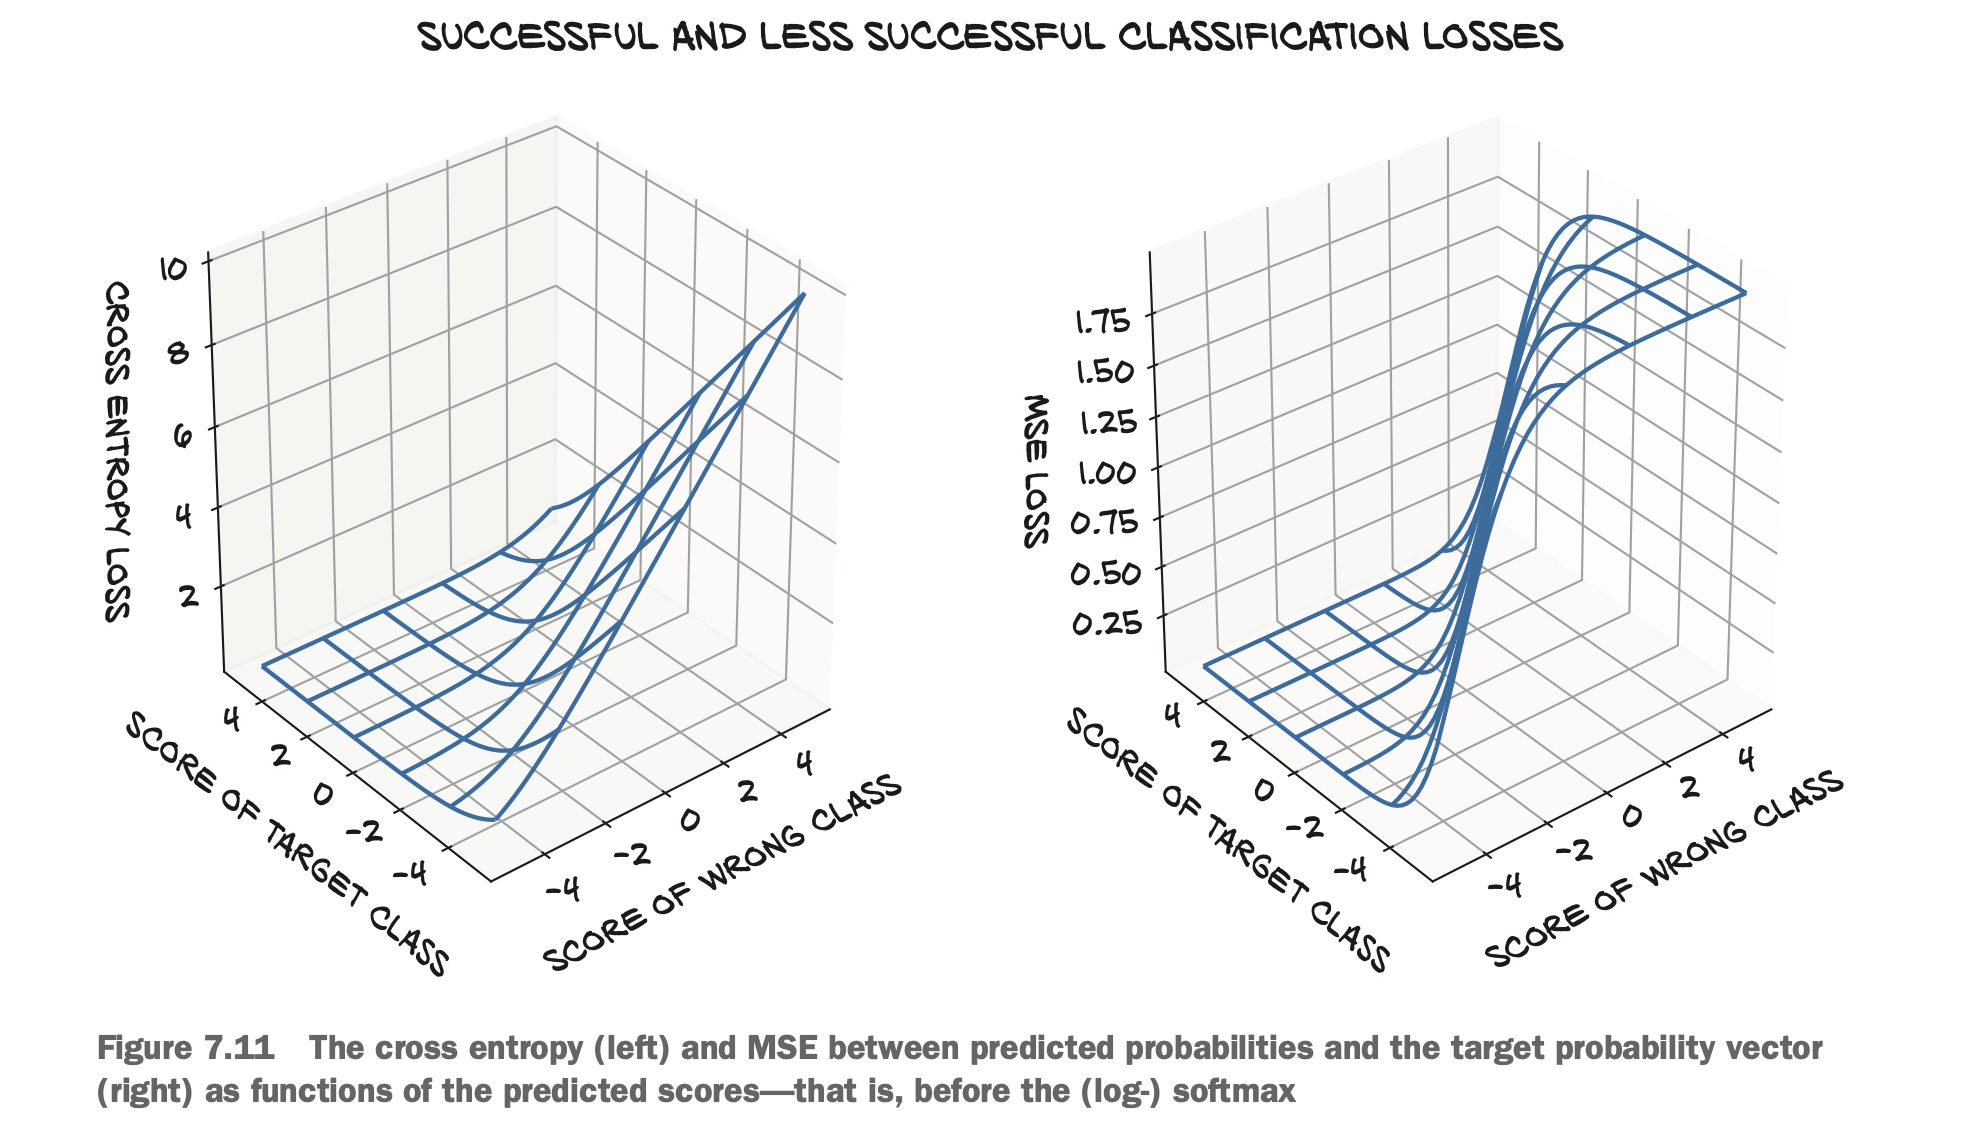

- Cross Entropy Loss 작동 방식
    - 정답 클래스의 점수가 높을수록 손실이 급격하게 낮아진다.
    - 오답 클래스의 점수가 높아지면 손실이 급격하게 커진다.
    - 정답일 때 잘 맞추는 경우는 강하게 보상, 오답일 때는 매우 큰 패널티
    - 경사가 커서 잘못된 예측에 대해 신경망 파라미터가 크게 업데이트된다.
- MSE Loss 작동 방식
    - 정답클래스의 점수가 높아질수록 손실이 낮아지지만 경사는 훨씬 더 완만
    - 오답에 대해 낮은 점수를 줄 대도 손실이 빠르게  커지지 않는다
    - 즉 모델이 크게 틀리고 있어도 업데이트 폭이 작다.

### 7.2.6 분류기 훈련


In [ ]:
import torch
import torch.nn as nn
model = nn.Sequential(
    nn.Linear(3*32*32, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100


for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch %d, Loss : %f" % (epoch, float(loss)))



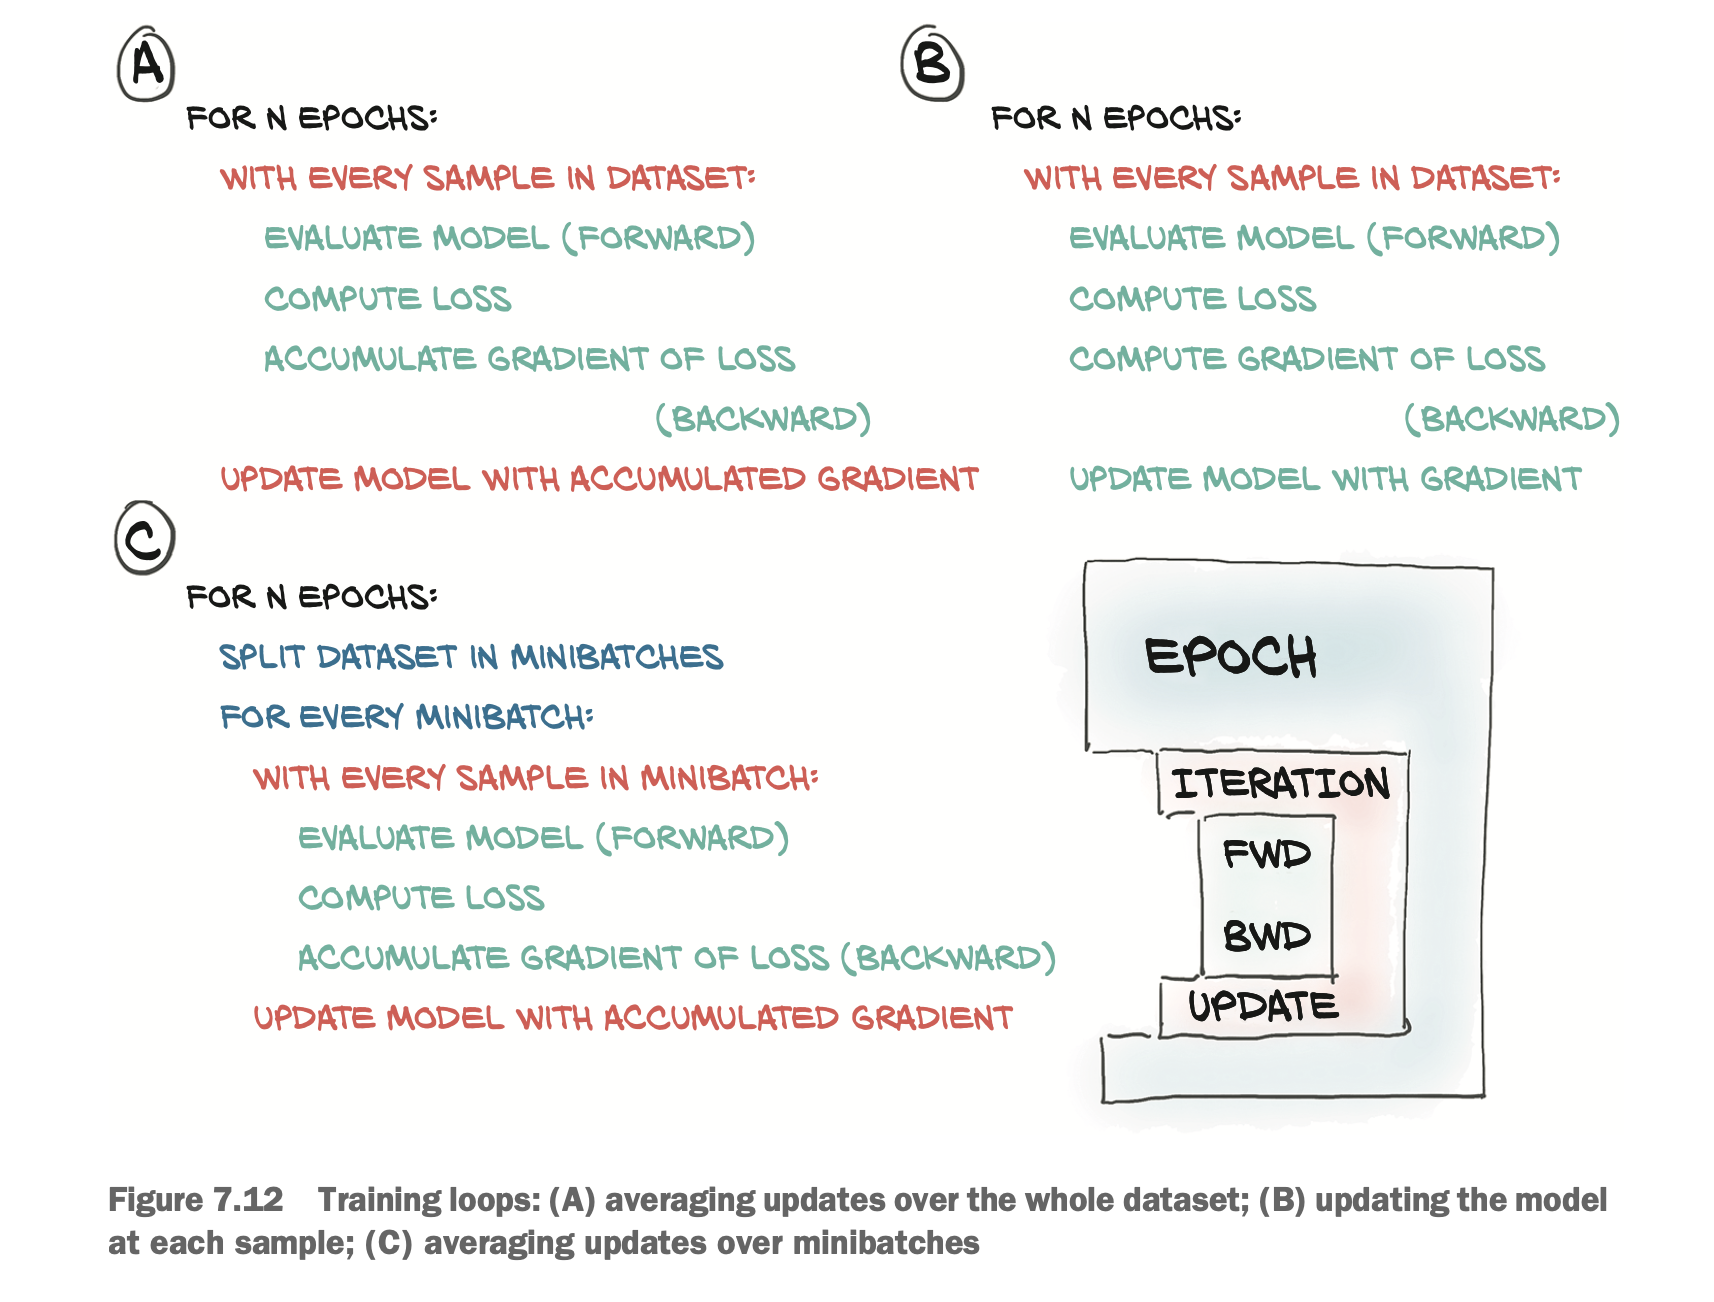

####  딥러닝에서 모델 파라미터 업데이트를 언제, 어떤 방식으로 하느냐에 다른 3가지 학습 루프

A. 전체 데이터셋 평균 업데이트(Batch gradient descent)
 - 프로세스 : 각 epoch마다 데이터셋의 모든 샘플에 대한 graient를 합산한 후 , 한번만 파라미터를 업데이트
 - 특징 : 전체 데이터를 다 보고 나서야 한번 update함 -> 안정적이고 느리지만, 큰 데이터셋에서는 계산량이 많음.

B. 샘플 단위 즉시 업데이트(Stochastic Gradient Descent / SGD)
 - 프로세스 : 각 샘플을 처리할 때마다, 즉시 파라미터를 업데이트
 - 특징 : 업데이트가 매우 빠르지만, gradient가 샘플 하나에만 의존하므로 매우 불안정할 수 있음.

C. 미니 배치 평균 업데이트(mini batch gradient descent)
 - 프로세스 : 데이터셋을 작은(mini)이지만 여러 샘플을 포함한 묶음들(minibatch)로 나눈 뒤, 각 minibatch마다 gradient를 합산해 파라미터로 업데이트
 - 특징 : batch 전체와 sample 개별의 중간 절충안


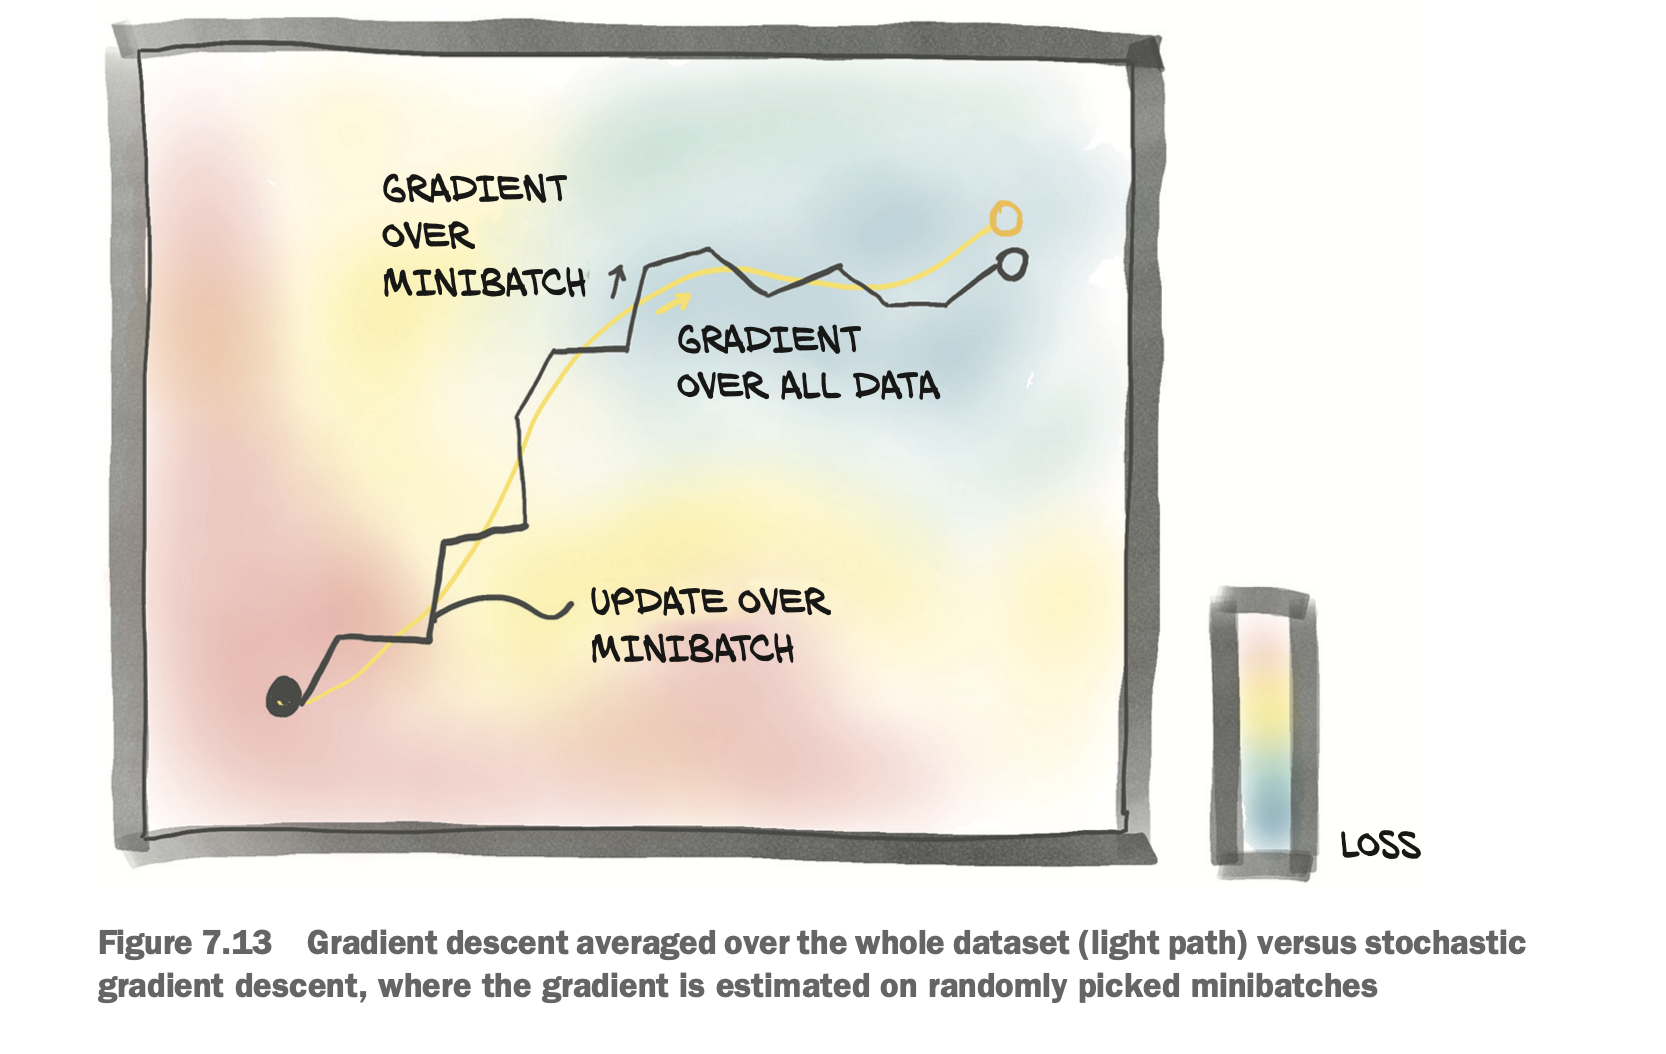

In [ ]:
# 하이퍼 파라미터 - 미니 배치 크기
# 훈련 코드에서는 데이터셋에서 한번에 하나의 아이템을 골라 크기가 1인 미니 배치를 만든다.
# 미니 배치 데이터를 섞거나 구조화하는 작업을 돕는 DataLoader 클래스가 있다.
# 데이터 로더를 활용해 데이터셋에서 미니 배치에 포함될 샘플을 가져올 대 여러 가지 샘플링 전략 중 하나를 고를 수 있다.
# 가장 흔한 전략은 각 에포크마다 데이터를 섞은 후 고르게 샘플링하는 것이다.

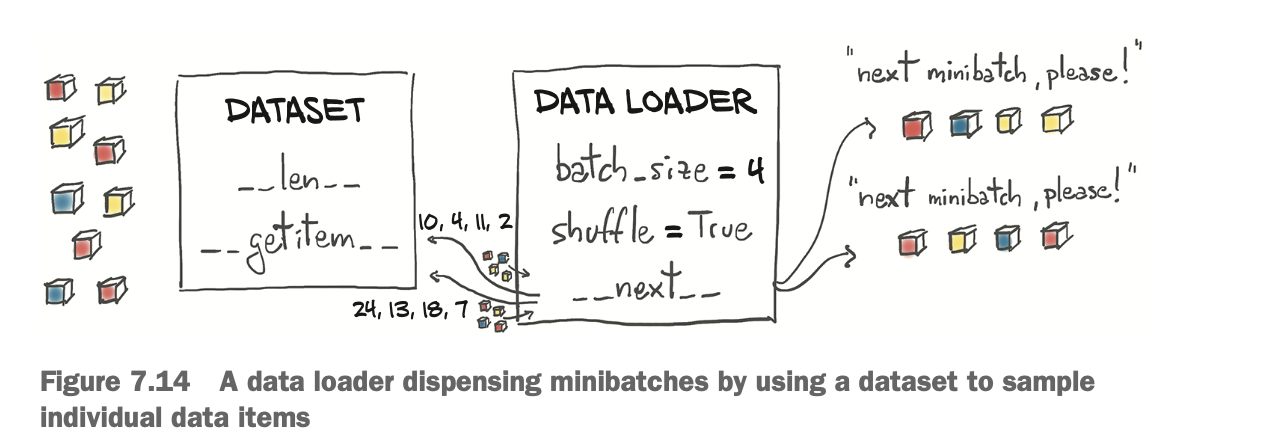

In [ ]:
# Dataloader는 순회 가능하기 때문에 다음과 같은 새로운 훈련 코드의 루프 안에 바로 넣어 사용할 수 있다.

import torch
import torch.nn as nn

train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

# model = nn.Sequential(
#     nn.Linear(3072, 512),
#     nn.Tanh(),
#     nn.Linear(512,2),
#     nn.LogSoftmax(dim=1)
# )

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# loss_fn = nn.NLLLoss()

n_epochs  = 30
for epoch in range(n_epochs):
    # 각 미니배치 (64) 별로
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        # 여기서 이미지를 view로 펼치는 이유는 신경망의 완전 연결층이 1차원 벡터만 입력받기 때문

        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
print("Epoch: %d, Loss: %f" % (epoch, loss))


In [ ]:
# 검증셋으로 테스트하여 전체 중에 정화갛게 분류된 숫자를 세어 모델의 정확도를 계산할 수 있다.
val_loader= torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = True)

correct = 0
total = 0

with torch.no_grad():
    for imgs,labels in val_loader:
        batch_size = imgs.shape[0]
        # val_loader 에서 배치 사이즈만큼 로드된다.
        outputs= model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())
print(f"Accuracy : {correct/total}") #Accuracy : 0.7655




In [ ]:
# 모델에 계층을 더 추가해보자

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),
    nn.LogSoftmax(dim=1)
)


- nn.LogSoftmax + nn.NLLLoss 조합은 nn.CrossEntropyCross와 동일함.

- nn.LogSoftmax + nn.NLLLoss
    - 입력값 : Log-softmax가 이미 적용된 값(각 클래스의 log 확률)
    - 동작 : NLLLoss는 정답 클래스의 log 확률만 뽑아 negative log likelihood를 계산함. 이게 곧 cross entropy가 됨.
    - 사용법 : 모델 마지막에 log-sofrmax 레이어를 씌운 뒤, NLLLoss를 씀
- nn.CrossEntropyLoss
    - 입력값 : 로짓(logits, softmax를 거치지 않은 점수)
    - 동작 : 내부적으로 Softmax -> Log -> NLLLoss를 한번에 수행함
        - 입력된 점수에 소프트맥스를 적용해 확률로 바꾼 뒤, 로그를 취하고 실제 정답 클래스를 골라 negative log likelihood를 계산한다.
    - 사용법 : 모델의 마지막 레이어에는 softmax,(log softmax 필요없음) 바로 로직을 반환해야함.

In [ ]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,128),
    nn.Tanh(),
    nn.Linear(128,2),
)
loss_fn = nn.CrossEntropyLoss()

#### 이렇게 하면 모델의 출력을 확률로 해석 가능하지 못하는 단점이 있다.
그래서 이를 구하기 위해 출력을 다시 소프트맥스에 명시적으로 연결할 필요가 있다.

- nn.CrossEntropyLoss()는 입력값이 softmax 이전의 logit이길 기대한다
- 즉 모델의 마지막 레이어는 그냥 nn.Linear로 끝나고, softmax는 따로 적용하지 않는다.
- 이 함수는 내부적으로 softmax와 log 연산을 모두 처리해서 바로 logit을 넣어도 손실 계산이 가능하다.

- 만약 확률이 필요하다면?
    - 모델의 출력값(logit)은 0~1 사이의 확률이 아니고 그냥 실수값이다.
    - 예측 결과를 확률로 해석하고 싶다면, 직접 softmax를 적용해서 확률로 변환해야한다.

In [ ]:
# 각 텐서 객체에 얼마나 많은 요소가 있는지
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

# (3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

# 먀야야야 370만개가 넘는 파라미터가 있다.
# 조그마한 입력이미지를 다룰만한 작은 신경망이라고 보긴 어렵지 않아?
# 심지어 첫번째 신경망도 꽤나 크다.

In [ ]:
model

In [ ]:
numel_list = [  p.numel() for p in model[2].parameters()]
sum(numel_list),numel_list

In [ ]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

# 우리의 신경망이 픽셀 수에 따라 확장 가능하기 어렵다.
'''
완전연결층은 입력이미지의 픽셀 수가 바뀌면 구조 자체를 바꿔야하므로, 다양한 크기의 이미지를 유연하게 처하기 어렵다는 뜻
이 구조는 고정된 크기의 입력만 처리할 수 있다.
이미지 크기가 바뀌면 Linear 레이어의 입력 차원도 반드시 바꿔줘야한다.

'''

### 7.2.7 완전 연결의 한계
![image.png]()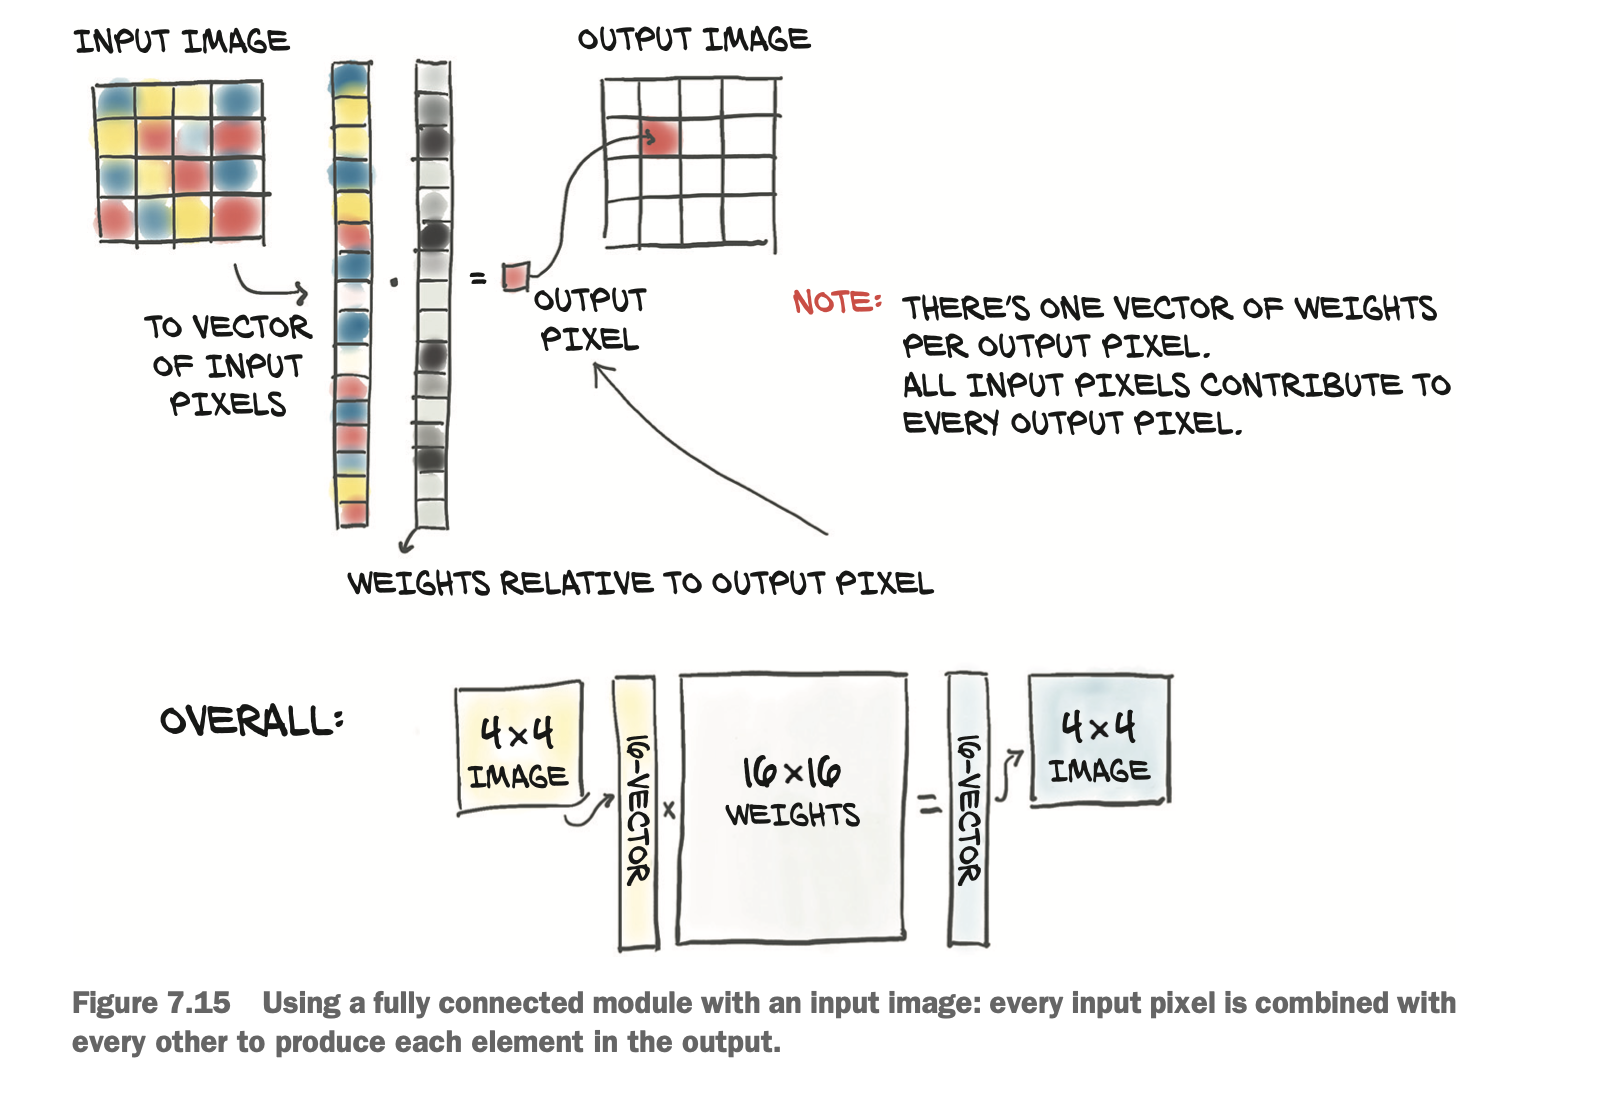

#### 완전 연결층(Linear Layer)로 이미지를 벡터로 펼칠 때의 의미

1. 모든 픽셀 조합이 가능하다.
- 이미지를 1차원 벡터로 펼쳐서 완전 연결층에 넣으면,
    - 모든 입력 픽셀(특징)이 모든 출력 뉴런과 연결된다.
    - 이미지의 어떤 픽셀과 다른 어떤 픽셀의 조합도 모델이 자유롭게 학습할 수 있다.
    - 이론적으로는 이미지 전체의 모든 부분이 서로 영향을 주고 받을 수 있으니 복잡한 관계도 표현 가능하다.
2. 공간적 (위치) 정보는 무시된다.
- 하지만 이미지를 벡터로 펼치면, 이웃한 픽셀과 멀리 떨어진 픽셀의 상대적 위치 정보가 사라진다.
- 이미지의 공간적 구조(패턴, 모양, 위치 등)는 모델이 알 수 없고, 모든 픽셀을 독립적으로 취급하게 된다.
---

이 때문에 이미지 처리에서는 **합성곱 신경망** CNN이 더 많이 쓰인다.
CNN은 이웃 픽셀의 관계를 잘 활용할 수 있기 떄문이다.

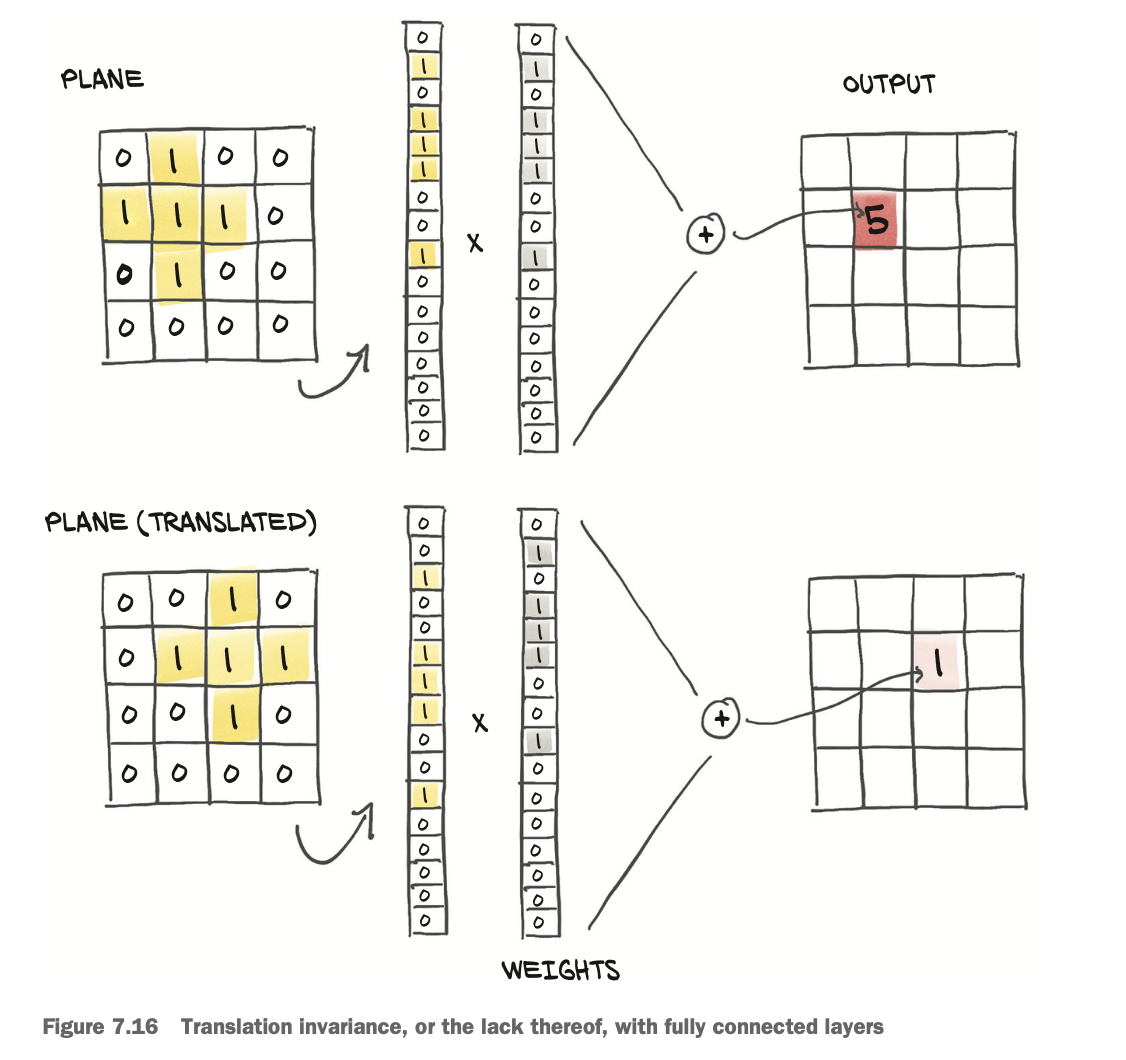

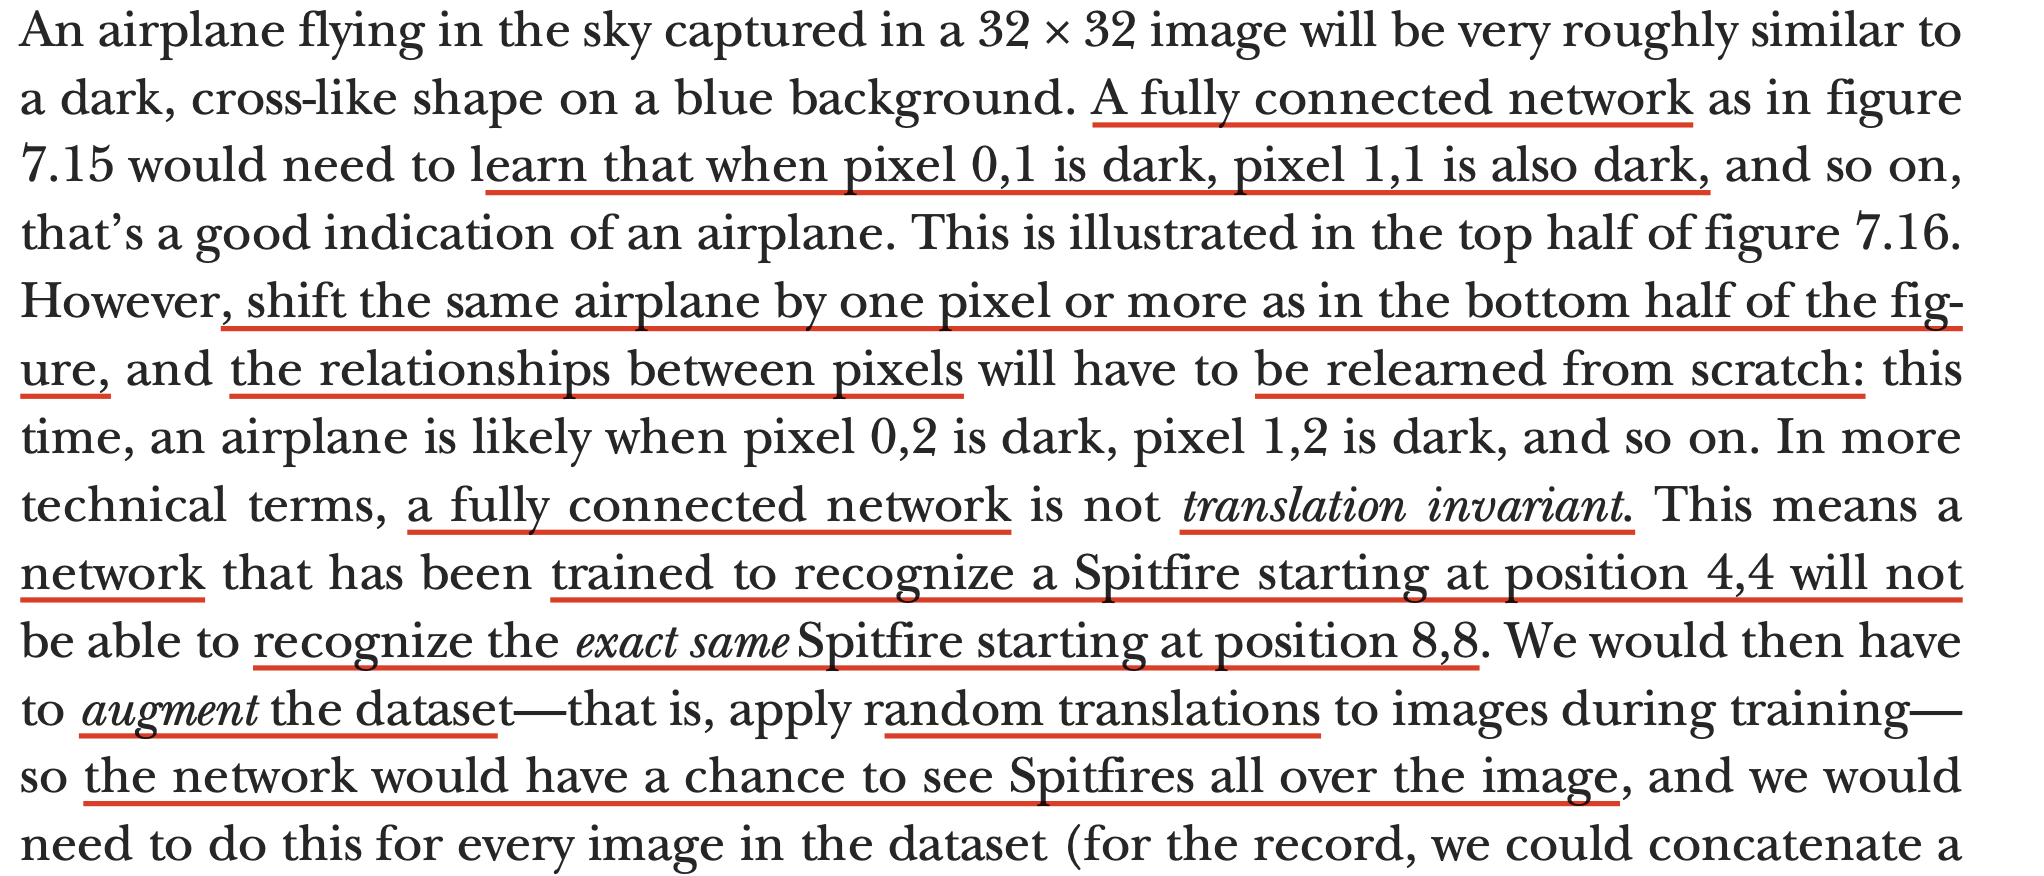

#### 그림 설명
- 완전 연결 신경망은 translation invariance (평행 이동 불변성)이 없다.
- 이미지를 완전 연결 신경망 (fully connected layer)에 입력할 때, ***이미지의 위치가 조금만 바뀌어도 같은 모양을 인식하지 못하는 문제***점이 있다.

- 위쪽 그림
    - 원래 이미지는 중앙에 십자 모양이 있고, 이 십자 (노란색 픽셀)가 벡터로 펼쳐짐
    - 이 펼쳐진 벡터와 weight를 곱해서 출력 뉴런을 만들면, "비행기가 이 위치일 때는 strong(5)으로 인식"하게 된다.
- 아래쪽 그림
    - 똑같은 십자 모양이지만, 이미지를 오른쪽으로 한칸 옮겨서 중아이 아닌 다른 위치에 있음
    - 벡터로 펼치면 이전과 인덱스가 달라지고, 가중치와 곱하면 완전히 다른 결과(1)이 나온다.
    - 즉 같은 모양인데 위치만 바뀌어도 뉴런의 반응이 전혀 달라지는 것이다!
---

- 완전 연결층은 좌표 정보를 활용하지 않고, 각 픽셀의 위치까지 모두 고정해서 기억한다.
- 만약 비향기가 1칸만 움직이면, 픽셀 조합이 달라져서 모델은 다시 배워야한다.
- 이미지속 물체가 다양한 위치에 올수 있는데 완전 연결층은 그 위치가 변할 때마다 새롭게  연결부터 다시 학습해야한다.
- 같은 스핏파이어 전투기라고 (4,4)위치에 있을 때만 인식할 수 있고, (8,8)에 있으면 못 알아본다.
---

- 이 문제를 해결하기 위해서는 데이터 증강 (data augmentation, 즉 랜덤 위치로 이미지를 이동시켜서 학습)방법을 사용해야한다.
- 그러나 이 방식은 모든 위치에 있는 물체를 기억해야해서 파라미터 개수가 엄청 늘고 학습이 더 어려워진다.